<a href="https://colab.research.google.com/github/sreent/machine-learning/blob/main/K-Nearest%20Neighbours%20Regression/KNN%20Regression%20Hands-On%20Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Nearest Neighbors (KNN) Regression

In this lab, you will implement a K-Nearest Neighbors regressor from scratch, tune its hyperparameters, and apply it to synthetic and real datasets. Along the way, you'll explore the bias-variance tradeoff, understand the importance of feature scaling, and visualize how different K values affect model predictions. By the end, you will have a clear grasp of how KNN regression works, how to evaluate it using metrics like MSE and R², and why practices like proper data splitting and standardization are critical.

## Overview of KNN Regression

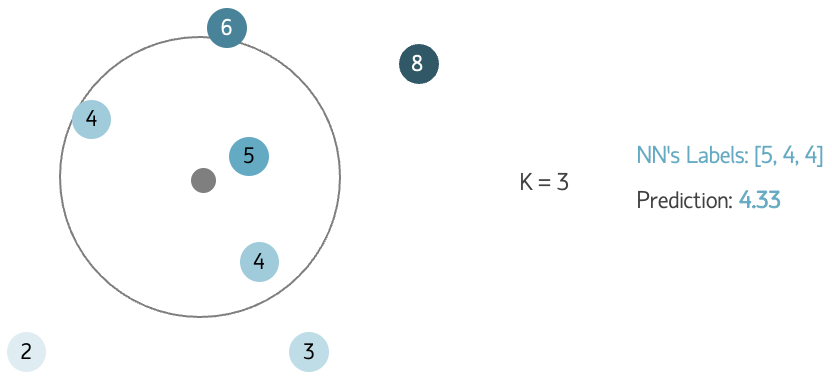
**Algorithm:**
1. Given a new data point $\mathbf{x}_{\text{new}}$, compute the distance from $\mathbf{x}_{\text{new}}$ to every point in the training set.
2. Select the K training points closest to $\mathbf{x}_{\text{new}}$ (the K nearest neighbors).
3. **Average** the target values of these K neighbors to produce the prediction:

$$\hat{y}_{\text{new}} = \frac{1}{K} \sum_{i=1}^{K} y_i$$

where $y_i$ are the target values of the K nearest neighbors.

**Key Difference from Classification:**
- **Classification**: Uses majority voting among K neighbors' class labels
- **Regression**: Averages the K neighbors' continuous target values

**Example:**
If K=3 and the 3 nearest neighbors have target values [2.5, 3.0, 2.8], the prediction would be:
$$\hat{y} = \frac{2.5 + 3.0 + 2.8}{3} = 2.77$$

## Visual K Progression

Before diving into implementation, let's visualize how the K parameter affects predictions step by step.

### Understanding K Through Visualization

When K=1, the algorithm considers only the single nearest neighbor, making predictions highly sensitive to individual data points. As K increases, predictions become smoother by averaging more neighbors, reducing sensitivity to outliers but potentially oversimplifying patterns in the data.

In [ ]:
# Visualize how K affects predictions
import numpy as np
import matplotlib.pyplot as plt

# Create simple dataset
np.random.seed(42)
X_simple = np.array([[1], [2], [3], [4], [5], [6], [7], [8], [9], [10]])
y_simple = np.array([2.1, 2.8, 3.9, 4.1, 5.2, 5.8, 6.1, 7.2, 8.9, 9.1])

# Test point
x_test = 5.5

# Visualize K progression
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
k_values = [1, 2, 3, 4, 5, 10]

for idx, k in enumerate(k_values):
    ax = axes[idx // 3, idx % 3]

    # Calculate distances
    distances = np.abs(X_simple.flatten() - x_test)
    nearest_indices = np.argsort(distances)[:k]

    # Make prediction
    prediction = np.mean(y_simple[nearest_indices])

    # Plot
    ax.scatter(X_simple, y_simple, c='blue', s=100, alpha=0.6, label='Training data')
    ax.scatter(X_simple[nearest_indices], y_simple[nearest_indices],
               c='red', s=200, marker='*', label=f'K={k} neighbors', zorder=3)
    ax.scatter(x_test, prediction, c='green', s=300, marker='X',
               label=f'Prediction={prediction:.2f}', zorder=4)

    # Draw circle showing radius
    circle = plt.Circle((x_test, prediction), distances[nearest_indices[-1]],
                        color='red', fill=False, linestyle='--', alpha=0.3)
    ax.add_patch(circle)

    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.set_title(f'K = {k}: Prediction = {prediction:.2f}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Test point X = {x_test}")
for k in k_values:
    distances = np.abs(X_simple.flatten() - x_test)
    nearest_indices = np.argsort(distances)[:k]
    prediction = np.mean(y_simple[nearest_indices])
    print(f"K={k:2d}: Prediction = {prediction:.2f}")

> **Question**: In KNN regression, the parameter K refers to:
>
> A. The number of features in the dataset  
>
> B. The number of nearest neighbors whose target values are averaged for prediction  
>
> C. The number of clusters in the data  
>
> D. The number of iterations for training
>


## Distance Metrics and Feature Scaling

**Common Distance Metrics:**
- **Euclidean (L2)**: $d(\mathbf{x}, \mathbf{x}') = \sqrt{\sum_{i=1}^{n} (x_i - x_i')^2}$
- **Manhattan (L1)**: $d(\mathbf{x}, \mathbf{x}') = \sum_{i=1}^{n} |x_i - x_i'|$
- **Minkowski**: Generalization of both (p=1 is Manhattan, p=2 is Euclidean)

**Feature Scaling is Critical:**
- Features with larger ranges dominate distance calculations
- Example: If feature1 ranges from 0-1 and feature2 from 0-1000, feature2 will dominate
- **Solution**: Standardize features to have mean=0 and std=1, or normalize to [0,1] range

$$z = \frac{x - \mu}{\sigma}$$

where $\mu$ is the mean and $\sigma$ is the standard deviation.

> **Question**: When using KNN on a dataset with features measured in very different scales (e.g., age in years vs. income in dollars), what should you do?
>
> A. Nothing—KNN handles different scales automatically  
>
> B. Remove the feature with the largest scale  
>
> C. Standardize or normalize all features to comparable ranges  
>
> D. Use only categorical features
>
>

## Pseudocode for KNN Regressor

Before implementing the algorithm, let's understand the pseudocode structure (from lecture slides):

```
# Inputs
#   data      ← training set of N examples (x, y)
#   k         ← number of neighbours
#   metric    ← distance function (e.g., Euclidean, Manhattan)
#   X_query   ← set of examples to predict

# ----- "fit" (lazy) -----
X_train ← data.x
y_train ← data.y

# ----- predict -----
ŷ ← list of length |X_query|  # outputs align 1:1 with X_query

FOR i = 1 TO |X_query| DO
    x* ← X_query[i]
    d ← distances from x* to all X_train using metric
    J ← indices of the k smallest values in d
    # regression prediction = average of the targets of the k nearest neighbours
    ŷ[i] ← mean(y_train[J])
END FOR

RETURN ŷ
```

**Key Points:**
- KNN is a "lazy learner" - the `fit` method just stores the training data
- The `predict` method does all the work: compute distances, find K nearest, average their targets
- **Regression uses averaging** (not voting like classification)

## Implementing a Custom KNN Regressor

Below is a scaffold of the `MyKNNRegressor` class. Fill in the TODO sections to complete the implementation.

In [ ]:
import numpy as np
from sklearn.metrics import pairwise_distances

class MyKNNRegressor:
    """
    A simple K-Nearest Neighbors Regressor implementation.

    Parameters:
    -----------
    n_neighbors : int, default=5
        Number of neighbors to use for prediction
    metric : str, default='euclidean'
        Distance metric to use ('euclidean', 'manhattan', etc.)
    """

    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """
        Fit the KNN regressor by storing the training data.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Training data
        y : array-like of shape (n_samples,)
            Target values
        """
        # TODO: Store the training data
        # Hint: KNN is a "lazy learner" - it just stores the training data
        self.X_train = ___
        self.y_train = ___
        return self

    def predict(self, X):
        """
        Predict target values for test data.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Test data

        Returns:
        --------
        predictions : array of shape (n_samples,)
            Predicted target values
        """
        predictions = []

        for x_test in X:
            # TODO: For each test point:
            # 1. Compute distances from x_test to all training points
            # 2. Find indices of K nearest neighbors
            # 3. Get target values of those K neighbors
            # 4. Average them to get the prediction

            # Step 1: Compute distances
            distances = pairwise_distances(
                x_test.reshape(1, -1),
                self._____,
                metric=self.metric
            ).ravel()

            # Step 2: Find K nearest neighbor indices
            k_nearest_indices = np.argsort(distances)[:self.n_neighbors]

            # Step 3: Get target values of K nearest neighbors
            k_nearest_targets = self.y_train[______]

            # Step 4: Average the target values
            prediction = np.mean(_______)

            predictions.append(prediction)

        return np.array(predictions)

print("MyKNNRegressor class defined successfully!")

Once you have filled in the implementation, let's test our custom regressor on a simple dataset.

## A Dataset for Visualization

We'll create a synthetic 1D regression dataset to visualize how KNN regression works.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic 1D data
def f(x):
    """True underlying function: sinusoidal pattern"""
    return np.sin(x) + 0.1 * x

# Training data
X_train_1d = np.sort(np.random.uniform(0, 10, 100))
y_train_1d = f(X_train_1d) + np.random.normal(0, 0.2, 100)  # Add noise

# Reshape for sklearn compatibility
X_train_1d = X_train_1d.reshape(-1, 1)

# Test data (for smooth prediction curve)
X_test_1d = np.linspace(0, 10, 200).reshape(-1, 1)
y_test_1d_true = f(X_test_1d.ravel())

print(f"Training data shape: X={X_train_1d.shape}, y={y_train_1d.shape}")
print(f"Test data shape: X={X_test_1d.shape}")

Let's visualize the training data:

In [ ]:
# Manual step-by-step prediction (matching lecture slides 11-13)
from sklearn.metrics import pairwise_distances

# Choose a test point (let's pick x=5.0 from our test range)
x_test_single = np.array([[5.0]])  # Must be 2D for sklearn
print("="*70)
print("STEP-BY-STEP: How KNN Predicts for x_test = 5.0")
print("="*70)

# Step 1: Calculate distances from test point to ALL training points
print("\nSTEP 1: Pairwise Distance Calculation")
print("-" * 70)
distances = pairwise_distances(x_test_single, X_train_1d, metric='euclidean').ravel()
print(f"Computed {len(distances)} distances from x_test=5.0 to all training points")
print(f"Distance array shape: {distances.shape}")
print(f"First 10 distances: {distances[:10].round(3)}")

# Step 2: Find K nearest neighbors
print("\nSTEP 2: Finding K Nearest Neighbors")
print("-" * 70)
K = 5
k_indices = np.argsort(distances)[:K]  # Indices of K smallest distances
k_distances = distances[k_indices]
print(f"K = {K}")
print(f"Indices of K nearest neighbors: {k_indices}")
print(f"Their distances: {k_distances.round(3)}")
print(f"Their x-coordinates: {X_train_1d[k_indices].ravel().round(3)}")

# Step 3: Get target values of K nearest neighbors
print("\nSTEP 3: Get Neighbor Targets")
print("-" * 70)
k_targets = y_train_1d[k_indices]
print(f"NN's Labels (target values): {k_targets.round(3)}")

# Step 4: Average to get prediction
print("\nSTEP 4: Average (THE PREDICTION!)")
print("-" * 70)
manual_prediction = np.mean(k_targets)
print(f"Prediction = mean({k_targets.round(3)})")
print(f"Prediction = {manual_prediction:.3f}")

# Verify with our custom KNN
knn_verify = MyKNNRegressor(n_neighbors=K)
knn_verify.fit(X_train_1d, y_train_1d)
verify_prediction = knn_verify.predict(x_test_single)[0]

print(f"\n" + "="*70)
print("VERIFICATION:")
print(f"  Manual calculation:  {manual_prediction:.3f}")
print(f"  MyKNNRegressor:      {verify_prediction:.3f}")
print(f"  Match: {np.isclose(manual_prediction, verify_prediction)} ✓")
print("="*70)

# Visualize this specific prediction
plt.figure(figsize=(12, 5))
plt.scatter(X_train_1d, y_train_1d, c='lightblue', alpha=0.6, edgecolor='k', s=50, label='All training data')
plt.scatter(X_train_1d[k_indices], k_targets, c='red', s=100, edgecolor='k',
           label=f'K={K} nearest neighbors', zorder=5)
plt.scatter(x_test_single, manual_prediction, c='green', s=200, marker='*',
           edgecolor='k', label='Prediction (average)', zorder=10)
plt.axhline(manual_prediction, color='green', linestyle='--', alpha=0.3)
plt.xlabel('X')
plt.ylabel('y')
plt.title(f'Step-by-Step KNN Prediction: x_test={x_test_single[0,0]}, K={K}, Prediction={manual_prediction:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Understanding the Prediction Process: Step-by-Step

Before we test different K values, let's manually walk through exactly what happens when KNN makes a single prediction. This matches the step-by-step process from the lecture slides (slides 11-13).

**The 4 Steps:**
1. **Pairwise Distance Calculation**: Compute distance from test point to all training points
2. **Finding K Nearest Neighbors**: Sort distances and select K smallest
3. **Get Neighbor Targets**: Retrieve the y-values of those K neighbors  
4. **Average**: Compute mean of the K target values → this is the prediction!

Let's demonstrate this process:

In [ ]:
plt.figure(figsize=(12, 5))

# Plot training data
plt.scatter(X_train_1d, y_train_1d, c='blue', alpha=0.6, edgecolor='k', s=50, label='Training data')
plt.plot(X_test_1d, y_test_1d_true, 'g--', lw=2, label='True function')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Training Data with True Underlying Function')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Model Complexity and Bias-Variance Tradeoff

Let's explore how different K values affect model complexity by testing a wider range: K=1, 5, 10, 15, 30, 50.

### Understanding the Tradeoff

- **Small K (e.g., K=1)**: High complexity, low bias, high variance → **Overfitting**
- **Moderate K (e.g., K=5-10)**: Balanced complexity → **Optimal**
- **Large K (e.g., K=30-50)**: Low complexity, high bias, low variance → **Underfitting**

In [ ]:
# Test extended range of K values with 2x3 subplot comparison
k_values_extended = [1, 5, 10, 15, 30, 50]

plt.figure(figsize=(18, 12))

for idx, k in enumerate(k_values_extended):
    # Train model
    knn_model = MyKNNRegressor(n_neighbors=k)
    knn_model.fit(X_train_1d, y_train_1d)

    # Predictions
    X_plot = np.linspace(X_train_1d.min(), X_train_1d.max(), 300).reshape(-1, 1)
    y_plot = knn_model.predict(X_plot)

    # Create subplot
    plt.subplot(2, 3, idx + 1)
    plt.scatter(X_train_1d, y_train_1d, c='blue', alpha=0.6, s=50, label='Training data')
    plt.plot(X_plot, y_plot, 'r-', linewidth=2, label=f'K={k} prediction')
    plt.xlabel('X')
    plt.ylabel('y')

    # Label overfitting/optimal/underfitting
    if k <= 3:
        region_label = 'OVERFITTING'
        color = 'red'
    elif k <= 15:
        region_label = 'OPTIMAL'
        color = 'green'
    else:
        region_label = 'UNDERFITTING'
        color = 'orange'

    plt.title(f'K = {k}\n[{region_label}]', color=color, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Model Complexity Analysis:")
print("  K=1:  Overfitting - follows training data too closely")
print("  K=5:  Optimal - good balance")
print("  K=10: Optimal - smooth and generalizes well")
print("  K=15: Still good - slightly smoother")
print("  K=30: Underfitting - too smooth, misses patterns")
print("  K=50: Severe underfitting - barely captures the trend")

> **Question**: Looking at the plots above, which K value shows signs of overfitting?
>
> A. K=30 (too smooth, doesn't follow the data closely)  
>
> B. K=1 (too wiggly, follows every noise point)  
>
> C. K=10 (balanced smoothness)  
>
> D. All of them equally
>


## Regression Line and MSE Formulas

### Understanding Prediction Errors

In regression, we measure how well our predictions match the actual values. The **error** (also called **residual**) for a single prediction is:

$$\text{Error (Residue)} = y - \hat{y}$$

Where:
- $y$ is the actual value
- $\hat{y}$ is the predicted value

### Mean Squared Error (MSE)

To evaluate overall model performance, we use Mean Squared Error:

$$\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y^{(i)} - \hat{y}^{(i)})^2$$

Where:
- $N$ is the number of samples
- Squaring emphasizes larger errors
- Lower MSE indicates better predictions

In [ ]:
# Visualize over-predicted and under-predicted points
np.random.seed(42)
X_error = np.linspace(0, 10, 20).reshape(-1, 1)
y_true = 2 * X_error.flatten() + np.random.randn(20) * 2

# Simple predictions (not perfect)
y_pred = 2 * X_error.flatten() + np.random.randn(20) * 1.5

# Calculate errors
errors = y_true - y_pred
mse = np.mean(errors**2)

# Visualize
plt.figure(figsize=(12, 6))

# Plot 1: Predictions vs Actual
plt.subplot(1, 2, 1)
plt.scatter(X_error, y_true, c='blue', s=100, alpha=0.6, label='Actual values')
plt.scatter(X_error, y_pred, c='red', s=100, marker='s', alpha=0.6, label='Predictions')

# Draw error lines
for i in range(len(X_error)):
    color = 'green' if y_pred[i] > y_true[i] else 'orange'
    plt.plot([X_error[i], X_error[i]], [y_true[i], y_pred[i]],
             color=color, linestyle='--', alpha=0.5)

plt.xlabel('X')
plt.ylabel('y')
plt.title('Predictions vs Actual Values')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Error distribution
plt.subplot(1, 2, 2)
colors = ['green' if e < 0 else 'orange' for e in errors]
plt.bar(range(len(errors)), errors, color=colors, alpha=0.6)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.xlabel('Sample Index')
plt.ylabel('Error (Residual)')
plt.title(f'Prediction Errors\nMSE = {mse:.2f}\nGreen=Over-predicted, Orange=Under-predicted')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")
print(f"Mean Absolute Error: {np.mean(np.abs(errors)):.2f}")

## Working with a Real Dataset

Now let's work with a real 2D regression dataset and compare our implementation with scikit-learn's.

In [ ]:
# TODO: Generate a 2D regression dataset with 300 samples and 2 features
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generate synthetic dataset
X, y = make_regression(n_samples=_________, n_features=_________,
                       n_informative=2, noise=15.0, random_state=42)


Visualize the 2D dataset with target values as colors:

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis',
                     edgecolor='k', s=50, alpha=0.7)
plt.colorbar(scatter, label='Target Value')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2D Regression Dataset (color represents target value)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Splitting into Train, Validation, and Test Sets

We split the data into:
- **Training set (60%)**: To fit the model
- **Validation set (20%)**: To tune hyperparameters (K)
- **Test set (20%)**: For final unbiased performance evaluation

In [ ]:
# TODO: Split data into train (60%), validation (20%), and test (20%) sets
# Split into train, validation, and test sets (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=_________)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=_________, random_state=42)

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")


After this split, you should see roughly: Train size 180, Validation size 60, Test size 60.

> **Question**: Why do we use a separate validation set instead of tuning the hyperparameters directly on the test set?
>
> A. The test set is too small  
>
> B. To prevent overfitting to the test set and get an unbiased final performance estimate  
>
> C. The validation set trains faster  
>
> D. It's just a convention with no real benefit
>

## Z-Score Standardization

Before we explore feature scaling in practice, let's understand the mathematical foundation.

### The Z-Score Formula

Standardization (Z-score normalization) transforms features to have mean $\mu = 0$ and standard deviation $\sigma = 1$:

$$Z = \frac{x - \mu}{\sigma}$$

Where:
- $x$ is the original value
- $\mu$ is the mean of the feature
- $\sigma$ is the standard deviation of the feature

### Why Z-Score Standardization Works

1. **Centers the data**: Subtracting the mean shifts the distribution to be centered at zero
2. **Scales the spread**: Dividing by standard deviation makes the spread consistent across features
3. **Preserves distribution shape**: Unlike min-max scaling, z-score maintains the original distribution's shape
4. **Handles outliers better**: Less sensitive to extreme values compared to min-max scaling

In [ ]:
# Visualize Z-score standardization
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
# Create two features with different scales
feature1 = np.random.normal(loc=100, scale=15, size=200)  # Mean=100, SD=15
feature2 = np.random.normal(loc=5, scale=2, size=200)     # Mean=5, SD=2

# Standardize
scaler = StandardScaler()
feature1_scaled = scaler.fit_transform(feature1.reshape(-1, 1)).flatten()
feature2_scaled = scaler.fit_transform(feature2.reshape(-1, 1)).flatten()

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Before standardization - Feature 1
axes[0, 0].hist(feature1, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(feature1.mean(), color='red', linestyle='--', linewidth=2, label=f'μ={feature1.mean():.1f}')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title(f'Feature 1 (Before)\nμ={feature1.mean():.1f}, σ={feature1.std():.1f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Before standardization - Feature 2
axes[0, 1].hist(feature2, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(feature2.mean(), color='red', linestyle='--', linewidth=2, label=f'μ={feature2.mean():.1f}')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'Feature 2 (Before)\nμ={feature2.mean():.1f}, σ={feature2.std():.1f}')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# After standardization - Feature 1
axes[1, 0].hist(feature1_scaled, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(feature1_scaled.mean(), color='red', linestyle='--', linewidth=2, label=f'μ={feature1_scaled.mean():.1f}')
axes[1, 0].set_xlabel('Value (Z-score)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Feature 1 (After)\nμ={feature1_scaled.mean():.2f}, σ={feature1_scaled.std():.2f}')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# After standardization - Feature 2
axes[1, 1].hist(feature2_scaled, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(feature2_scaled.mean(), color='red', linestyle='--', linewidth=2, label=f'μ={feature2_scaled.mean():.1f}')
axes[1, 1].set_xlabel('Value (Z-score)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'Feature 2 (After)\nμ={feature2_scaled.mean():.2f}, σ={feature2_scaled.std():.2f}')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Before Standardization:")
print(f"  Feature 1: μ={feature1.mean():.2f}, σ={feature1.std():.2f}, range=[{feature1.min():.2f}, {feature1.max():.2f}]")
print(f"  Feature 2: μ={feature2.mean():.2f}, σ={feature2.std():.2f}, range=[{feature2.min():.2f}, {feature2.max():.2f}]")
print("\nAfter Standardization:")
print(f"  Feature 1: μ={feature1_scaled.mean():.2f}, σ={feature1_scaled.std():.2f}, range=[{feature1_scaled.min():.2f}, {feature1_scaled.max():.2f}]")
print(f"  Feature 2: μ={feature2_scaled.mean():.2f}, σ={feature2_scaled.std():.2f}, range=[{feature2_scaled.min():.2f}, {feature2_scaled.max():.2f}]")

## Feature Scaling

Let's demonstrate the importance of feature scaling by comparing scaled vs. unscaled features.

### 1. Unscaled Features

When features are on different scales (e.g., one feature ranges from 0-100, another from 0-1), KNN will be dominated by the feature with the larger scale, since distance calculations are sensitive to magnitude.

### 2. Scaled Features

After standardization, all features contribute equally to the distance calculation, typically leading to much better performance.

In [ ]:
# TODO: Compare model performance with and without feature scaling
from sklearn.metrics import mean_squared_error, r2_score

# Without scaling
knn_raw = MyKNNRegressor(n_neighbors=5)
knn_raw.fit(X_train, y_train)
y_val_pred_raw = knn_raw.predict(X_val)

# With scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(_________)
X_val_scaled = scaler.transform(_________)

knn_scaled = MyKNNRegressor(n_neighbors=5)
knn_scaled.fit(X_train_scaled, y_train)
y_val_pred_scaled = knn_scaled.predict(X_val_scaled)

# Compare performance
print(f"Without Scaling - MSE: {mean_squared_error(y_val, y_val_pred_raw):.2f}, "
      f"R²: {r2_score(y_val, y_val_pred_raw):.4f}")
print(f"With Scaling    - MSE: {mean_squared_error(y_val, y_val_pred_scaled):.2f}, "
      f"R²: {r2_score(y_val, y_val_pred_scaled):.4f}")


## Where Do Errors Come From?

Not all regions of the feature space are equally predictable. Let's visualize areas of **high certainty** vs **high ambiguity**.

### Understanding Prediction Certainty

- **High Certainty Regions**: Areas with many nearby training points, where neighbors agree
- **High Ambiguity Regions**: Sparse areas or regions where neighbors have varying target values

KNN errors are typically higher in:
1. Sparse regions (few training samples nearby)
2. Boundary regions (where the underlying function changes rapidly)
3. Noisy regions (where similar inputs have very different outputs)

In [ ]:
# Visualize high certainty vs high ambiguity regions
np.random.seed(42)

# Create dataset with varying density
X_dense = np.random.uniform(0, 5, (100, 2))  # Dense region
X_sparse = np.random.uniform(7, 10, (20, 2))  # Sparse region
X_combined = np.vstack([X_dense, X_sparse])

# Create target with noise
y_combined = (2 * X_combined[:, 0] + X_combined[:, 1] +
              np.random.randn(len(X_combined)) * 0.5)

# Train a KNN model
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_combined, y_combined)

# Create prediction grid
x1_range = np.linspace(-1, 11, 100)
x2_range = np.linspace(-1, 11, 100)
xx1, xx2 = np.meshgrid(x1_range, x2_range)
grid_points = np.c_[xx1.ravel(), xx2.ravel()]

# Get predictions
predictions = knn.predict(grid_points)

# Calculate local density (number of neighbors within radius)
from sklearn.neighbors import NearestNeighbors
nn_model = NearestNeighbors(radius=1.5)
nn_model.fit(X_combined)
densities = [len(nn_model.radius_neighbors([point], return_distance=False)[0])
             for point in grid_points]

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Predictions with training data
scatter1 = axes[0].scatter(X_combined[:, 0], X_combined[:, 1],
                           c=y_combined, s=100, cmap='viridis',
                           edgecolors='black', linewidth=1.5, zorder=3)
contour1 = axes[0].contourf(xx1, xx2, predictions.reshape(xx1.shape),
                            levels=20, cmap='viridis', alpha=0.3)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title('KNN Predictions (K=5)')
plt.colorbar(scatter1, ax=axes[0], label='Target Value')
axes[0].grid(True, alpha=0.3)

# Add region labels
axes[0].text(2.5, 8, 'High Certainty\n(Dense Region)',
            bbox=dict(boxstyle='round', facecolor='green', alpha=0.3),
            fontsize=10, ha='center')
axes[0].text(8.5, 8, 'High Ambiguity\n(Sparse Region)',
            bbox=dict(boxstyle='round', facecolor='red', alpha=0.3),
            fontsize=10, ha='center')

# Plot 2: Prediction certainty (based on density)
contour2 = axes[1].contourf(xx1, xx2, np.array(densities).reshape(xx1.shape),
                            levels=20, cmap='RdYlGn', alpha=0.8)
axes[1].scatter(X_combined[:, 0], X_combined[:, 1],
               c='black', s=50, marker='x', zorder=3, label='Training points')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title('Prediction Certainty\n(Green=High, Red=Low)')
plt.colorbar(contour2, ax=axes[1], label='Number of neighbors')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Prediction Certainty Analysis:")
print(f"  Dense region (0-5): {len(X_dense)} training points")
print(f"  Sparse region (7-10): {len(X_sparse)} training points")
print(f"  Maximum neighbors in radius: {max(densities)}")
print(f"  Minimum neighbors in radius: {min(densities)}")
print("\nInterpretation:")
print("  - Green regions: High certainty (many nearby training points)")
print("  - Red regions: High ambiguity (few nearby training points)")
print("  - Errors are typically higher in red (sparse/ambiguous) regions")

## Tuning the Hyperparameter K

Let's find the optimal K by evaluating different values on the validation set.

In [ ]:
# TODO: Find optimal K by evaluating on validation set
# TODO: Track both training and validation RMSE

# Lists to store metrics
train_rmse = []
val_rmse = []
k_range = range(1, 51)

# Loop through different K values
for k in k_range:
    # Train model with current K
    knn = MyKNNRegressor(n_neighbors=_________)
    knn.fit(X_train_scaled, y_train)
    
    # Predictions
    y_train_pred = knn.predict(X_train_scaled)
    y_val_pred = knn.predict(_________)
    
    # Calculate RMSE
    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    val_rmse.append(np.sqrt(mean_squared_error(y_val, _________)))

# Find best K
best_k = list(k_range)[np.argmin(val_rmse)]
print(f"\nBest K: {best_k}")
print(f"Best Validation RMSE: {min(val_rmse):.2f}")


Now, let's plot the RMSE vs. K to visualize the bias-variance tradeoff:

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(list(k_range), train_rmse, 'o-', label='Training RMSE', linewidth=2, markersize=6)
plt.plot(list(k_range), val_rmse, 's-', label='Validation RMSE', linewidth=2, markersize=6)
plt.axvline(best_k, linestyle='--', color='red', linewidth=2, label=f'Best K={best_k}')
plt.xlabel('K (Number of Neighbors)', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('Bias-Variance Tradeoff: RMSE vs K', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Small K: Low training RMSE (fits training data closely) but higher validation RMSE (overfitting)")
print("- Large K: Training and validation RMSE converge (underfitting - too much smoothing)")
print(f"- Optimal K={best_k}: Best balance between bias and variance")

### 3D Regression Surface Visualization

Let's visualize how the regression surface changes with different K values in 3D space.
This helps us understand:
- **K=5**: Optimal balance, smooth surface that captures the trend
- **K=10**: Slightly smoother, may miss some local variations
- **K=30**: Over-smoothed, underfitting the data

In [ ]:
# 3D Regression Surface for different K values
from mpl_toolkits.mplot3d import Axes3D

# Use only first 2 features for visualization
X_2d = X_train_scaled[:, :2]
y_2d = y_train

# Create grid for surface
x1_range = np.linspace(X_2d[:, 0].min() - 0.5, X_2d[:, 0].max() + 0.5, 30)
x2_range = np.linspace(X_2d[:, 1].min() - 0.5, X_2d[:, 1].max() + 0.5, 30)
xx1, xx2 = np.meshgrid(x1_range, x2_range)
grid_points = np.c_[xx1.ravel(), xx2.ravel()]

# Create figure with subplots
fig = plt.figure(figsize=(18, 5))
k_values_3d = [5, 10, 30]
titles = ['K=5: Optimal', 'K=10: Balanced', 'K=30: Underfitting']

for idx, (k, title) in enumerate(zip(k_values_3d, titles)):
    # Train model
    knn_3d = MyKNNRegressor(n_neighbors=k)
    knn_3d.fit(X_2d, y_2d)

    # Predict on grid
    predictions = knn_3d.predict(grid_points)
    zz = predictions.reshape(xx1.shape)

    # Create 3D subplot
    ax = fig.add_subplot(1, 3, idx + 1, projection='3d')

    # Plot surface
    surf = ax.plot_surface(xx1, xx2, zz, cmap='viridis', alpha=0.6, edgecolor='none')

    # Plot training points
    ax.scatter(X_2d[:, 0], X_2d[:, 1], y_2d, c='red', s=20, alpha=0.6, label='Training data')

    ax.set_xlabel('Feature 1 (scaled)')
    ax.set_ylabel('Feature 2 (scaled)')
    ax.set_zlabel('Target Value')
    ax.set_title(title)
    ax.view_init(elev=20, azim=45)

    # Add colorbar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

print("3D Surface Interpretation:")
print("  K=5:  Captures data trends well, some local variations")
print("  K=10: Smoother surface, good generalization")
print("  K=30: Very smooth, may be too simple (underfitting)")

## Comparing with Scikit-Learn's Implementation

Let's verify our implementation matches scikit-learn's KNeighborsRegressor.

In [ ]:
# TODO: Compare your implementation with scikit-learn's KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor

# Our implementation
our_knn = MyKNNRegressor(n_neighbors=best_k)
our_knn.fit(_________, y_train)
y_val_pred_ours = our_knn.predict(X_val_scaled)

# Scikit-learn's implementation
sklearn_knn = KNeighborsRegressor(n_neighbors=_________)
sklearn_knn.fit(X_train_scaled, y_train)
y_val_pred_sklearn = sklearn_knn.predict(_________)

# Compare
print(f"Our Implementation    - RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred_ours)):.2f}")
print(f"Scikit-learn          - RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred_sklearn)):.2f}")
print(f"Difference: {abs(np.sqrt(mean_squared_error(y_val, y_val_pred_ours)) - np.sqrt(mean_squared_error(y_val, y_val_pred_sklearn))):.4f}")


## Final Evaluation on Test Set

Now that we've chosen the best K using the validation set, let's evaluate on the held-out test set to get an unbiased performance estimate.

In [ ]:
# TODO: Evaluate final model on test set
from sklearn.metrics import mean_absolute_error

# Scale test set
X_test_scaled = scaler.transform(_________)

# Train final model on combined train+val data
X_train_val = np.vstack([X_train_scaled, X_val_scaled])
y_train_val = np.concatenate([y_train, y_val])

final_knn = MyKNNRegressor(n_neighbors=_________)
final_knn.fit(X_train_val, y_train_val)
y_test_pred = final_knn.predict(_________)

# Evaluation metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test Set Performance:")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  MAE:  {test_mae:.2f}")
print(f"  R²:   {test_r2:.4f}")


Visualize predictions vs. actual values:

In [ ]:
plt.figure(figsize=(12, 5))

# Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.6, edgecolor='k', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Test Set: Actual vs Predicted\n(R² = {test_r2:.3f}, RMSE = {test_rmse:.2f})')
plt.legend()
plt.grid(True, alpha=0.3)

# Residuals
plt.subplot(1, 2, 2)
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.6, edgecolor='k', s=50)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary and Key Takeaways

In this lab, we:

- **Implemented KNN Regression from scratch**: Built a complete `MyKNNRegressor` class that predicts continuous values by averaging the K nearest neighbors
- **Explored the bias-variance tradeoff**: Observed how small K values lead to overfitting (high variance, low bias) while large K values lead to underfitting (low variance, high bias)
- **Visualized K progression**: Saw how predictions change as we increase K from 1 to larger values, demonstrating the smoothing effect
- **Understood distance metrics**: Learned why Euclidean distance is commonly used and how it's sensitive to feature scales
- **Mastered feature scaling**: Discovered that standardization (z-score normalization) is critical for KNN, transforming features to have mean=0 and standard deviation=1
- **Applied proper data splitting**: Used train/validation/test splits (60/20/20) to tune hyperparameters without overfitting
- **Tuned the hyperparameter K**: Found the optimal K by evaluating validation set performance and observing the U-shaped validation error curve
- **Analyzed prediction certainty**: Identified that errors are higher in sparse regions or areas with high ambiguity
- **Compared implementations**: Verified our custom KNN regressor matches scikit-learn's implementation
- **Evaluated with multiple metrics**: Used MSE, RMSE, MAE, and R² to comprehensively assess model performance

**Key Insights:**

1. **KNN is a lazy learner**: No training phase - all computation happens during prediction
2. **Feature scaling is essential**: Distance-based algorithms require features on similar scales
3. **K is crucial**: The choice of K controls the bias-variance tradeoff
4. **Computational cost**: KNN can be slow for large datasets since it requires distance calculations to all training points
5. **Works best with**: Low-dimensional data (curse of dimensionality affects high-dimensional spaces)

**When to use KNN Regression:**
- Small to medium-sized datasets
- Non-parametric problems (no assumption about data distribution)
- When you need an interpretable model
- When the decision boundary is irregular

**When NOT to use KNN Regression:**
- Very large datasets (computational cost)
- High-dimensional data (curse of dimensionality)
- When training time is critical (preprocessing step)
- When you need a simple model equation

### Final Conceptual Question

> **Question**: Which of the following statements about KNN regression is TRUE?
>
> A. KNN performs better with high-dimensional data due to increased information
>
> B. Increasing K always improves model performance on the validation set
>
> C. KNN requires feature scaling because distance calculations are sensitive to feature magnitudes
>
> D. KNN has a training phase where it learns parameters from the data

<details>
<summary>Click to reveal answer</summary>

**Correct Answer: C**

**Explanation:**
- **A is FALSE**: KNN suffers from the "curse of dimensionality" - performance degrades in high-dimensional spaces as distances become less meaningful
- **B is FALSE**: There's an optimal K value; increasing K beyond this leads to underfitting and worse performance
- **C is TRUE**: Distance-based algorithms like KNN are highly sensitive to feature scales, making standardization essential
- **D is FALSE**: KNN is a lazy learner with no training phase; all computation happens during prediction

</details>

## Additional Exercises

1. **Try different distance metrics**: Modify `MyKNNRegressor` to use Manhattan distance and compare performance

2. **Feature engineering**: Create polynomial features and see if KNN performance improves

3. **Cross-validation**: Instead of a single validation split, implement k-fold cross-validation to choose K

4. **Computational efficiency**: Measure prediction time for different dataset sizes. How does it scale?

5. **Real dataset**: Apply KNN regression to the California Housing dataset and tune all hyperparameters

6. **Comparison**: Compare KNN with Linear Regression, Decision Trees, and Random Forest on the same dataset

> **Congratulations!** You've successfully implemented and mastered K-Nearest Neighbors regression from scratch. You now understand:
> - How KNN makes predictions by averaging neighbors
> - The critical importance of feature scaling
> - How to tune K using validation sets
> - The bias-variance tradeoff in action
>
> **Next Steps**: Try applying KNN to real-world regression problems, experiment with different distance metrics, and explore weighted KNN where closer neighbors have more influence!
>
> Keep learning and experimenting! The best way to master machine learning is through hands-on practice.